## Step 1: collect the snapshots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton_krylov
%matplotlib inline

In [2]:
def analytic_solution(x, t, alpha=1., beta=2., k=1.):
    z = ((-x/alpha + t) +beta*(x/alpha + t))/(2.*k)
    #print(z)
    return np.arccos(2 * np.tanh(z) * np.tanh(z) - 1)

def one_soliton_solution(x, t, m=2.):
    assert m > 1.0
    beta = np.sqrt(m * m -1.)/m
    return 4. * np.arctan(np.exp((x - beta * t)/np.sqrt(1 - beta * beta)))

def two_soliton_solution(x, t, m=2.):
    assert m > 1.0
    beta = np.sqrt(m * m - 1.)/m
    return 4. * np.arctan(beta * np.sinh(beta * m * x)/np.cosh(beta * m * t))

def sine_gordon_scheme(nx, nt, ic, x_range=[-20, 20], t_range=[0, 30]):
    """
    use implicit time advancing scheme. Runs too slow.
    """
    a, b = x_range
    t_min, t_max = t_range
    x = np.linspace(a, b, nx + 1)
    dx, dt = (b - a)/nx, (t_max - t_min)/nt
    
    #define initial condition
    z_prev, z, z_next = ic(x, t_min), ic(x, t_min + dt), np.zeros(nx + 1)
    b_left, b_right = z_prev[0], z_prev[-1]
    
    Z = np.zeros((nt + 2, nx + 1))
    Z[0, :] = z_prev
    Z[1, :] = z
    
    for t in range(nt):
        z_left = np.concatenate([[b_left], z[:-1]])
        z_right = np.concatenate([z[1:], [b_right]])
        
        lambd = (dt/dx) * (dt/dx)
        print(t)
        def residual(z_new):
            z_left = np.concatenate([[b_left], z_new[:-1]])
            z_right = np.concatenate([z_new[1:], [b_right]])
            return z_new - (2 * ( 1- lambd) * z - z_prev + lambd * (z_left + z_right) - dt * dt * np.sin(z_new))
        
        initial_guess = z
        z_next = newton_krylov(residual, initial_guess)
        print(z_next)
        z_prev, z = z, z_next
        Z[t + 2, :] = z
    return x, Z

In [ ]:
x, Z = sine_gordon_scheme(400, 300, two_soliton_solution)

In [3]:
nx = 400
nt = 400
x = np.linspace(-20, 20, 400)
Z = np.zeros((nt, nx))
for t in range(nt):
    time = 0.05 * t
    Z[t, :] = two_soliton_solution(x, time)
    
# scale so that the largest entries in Z <= 1
Z_0 = np.max(np.abs(Z))
Z = Z/Z_0

## Step 2: Use autoencoder to obtain reduced order basis
* Snapshots stored in `Z`
* `tf.Session()` here is the training session

training stage finished


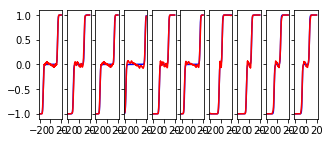

In [6]:
# see https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py
# for reference. simplify some places with tensorflow utility functions.
import tensorflow as tf

"""
parameters for the network
"""
Phi = Z.copy()
n_input = nx = Phi.shape[1]
n_hidden_1 = int(nx/4)
n_hidden_2 = 5
# TODO: use everything here to train
X_train = Phi
N = X_train.shape[0]
X_val = Phi[N:, :]
batch_size = 10
training_epoch = 200
lr = 0.001

"""
define the computational graph
"""
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder("float", [None, n_input])

def encoder(x):
    y = tf.layers.dense(x, n_hidden_1, activation=tf.nn.tanh)
    z = tf.layers.dense(y, n_hidden_2, activation=tf.nn.tanh)
    return z

def decoder(x):
    y = tf.layers.dense(x, n_hidden_1, activation=tf.nn.tanh)
    z = tf.layers.dense(y, n_input, activation=tf.nn.tanh)
    return z

encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

y_pred = decoder_op
y_true = X

cost = tf.nn.l2_loss(y_pred - y_true)
optimizer = tf.train.RMSPropOptimizer(lr).minimize(cost)

init = tf.global_variables_initializer()

loss_history = list()
sess.run(init)

for epoch in range(training_epoch):
    np.random.shuffle(X_train)
    total_batch = int(N/batch_size)
    for i in range(total_batch):
        begin, end = i * batch_size, min(N, (i + 1) * batch_size)
        X_b = X_train[begin:end, :]
        _, c = sess.run([optimizer, cost], feed_dict={X:X_b})
        loss_history.append(c)

print("training stage finished")
fig, ax = plt.subplots()
ax.plot(loss_history)

recon_Phi = sess.run(y_pred, feed_dict={X:Phi})

fig, ax = plt.subplots(1, 10, figsize=(5, 2), sharey=True)
for i in range(10):
    idx = np.random.randint(N)
    ax[i].plot(x, Phi[idx, :], 'b-', x, recon_Phi[idx, :], 'r-')
plt.show()

In [7]:
# get the weights for decoder
weights = dict()
for v in tf.trainable_variables():
    value = v.eval(session=sess)
    weights[v.name] = value

for k in weights.keys():
    print(k)
    print(weights[k].shape)

dense/kernel:0
(400, 100)
dense/bias:0
(100,)
dense_1/kernel:0
(100, 5)
dense_1/bias:0
(5,)
dense_2/kernel:0
(5, 100)
dense_2/bias:0
(100,)
dense_3/kernel:0
(100, 400)
dense_3/bias:0
(400,)


In [14]:
from statsmodels.tsa.api import VAR, DynamicVAR

training_data = Phi[:250, :]
validation_data = Phi[250:, :]
ys = sess.run(encoder_op, feed_dict={X:training_data})
#print(ys)
model = VAR(ys)
results = model.fit(5)
y_forecast = results.forecast(ys[-5:], 150)
y_actual = sess.run(encoder_op, feed_dict={X:Phi})

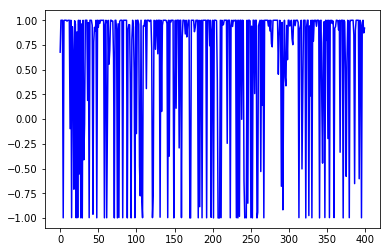

In [18]:
fig, ax = plt.subplots()
plt.plot(y_actual[:, 1], 'b-')

## Step 3: Use ARIMA to represent low dimensional PDE

In [ ]:
# redfine the graph to run decoder
tf.reset_default_graph()
sess = tf.Session()
X = tf.placeholder("float", [None, 5])

W0 = tf.Variable(initial_value=weights['dense_2/kernel:0'])
b0 = tf.Variable(initial_value=weights['dense_2/bias:0'])
W1 = tf.Variable(initial_value=weights['dense_3/kernel:0'])
b1 = tf.Variable(initial_value=weights['dense_3/bias:0'])

def explicit_decoder(x, W0, b0, W1, b1):
    y = tf.nn.sigmoid(x @ W0 + b0)
    z = tf.nn.sigmoid(y @ W1 + b1)
    return z

Y = explicit_decoder(X, W0, b0, W1, b1)

init = tf.global_variables_initializer()
sess.run(init)
Y_forecast = sess.run(Y, feed_dict={X:y_forecast})

np.linalg.norm(Y_forecast - Phi[250:, :], ord='fro')/(np.sqrt(np.product(Y_forecast.shape)))

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, Y_forecast[0, :], 'b-', x, Y_forecast[5, :], 'k-', x, Phi[300, :], 'r-')